<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install -q datasets jiwer


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

df = pd.read_csv('./tibetan_dataset/labels.csv', sep=',', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,1-1-99a_line_9874_3.jpg,ཅིག་ལྗོངས་རྒྱུར་འགྲོ་མི་ནུས་སོ། །དེ་ཅིའི་ཕྱིར་...
1,1-1-99a_line_9874_4.jpg,དང་ཐབས་ཅིག་ལྗོངས་རྒྱུར་འགྲོ་མི་ནུས་སོ། །དེ་ཅིའ...
2,1-1-99a_line_9874_5.jpg,དཔོན་དག་མི་གདོང་ན། མྱུར་དུ་ལྡོག་པ་དང༌། སྐྱེན་པ...
3,1-1-99a_line_9874_6.jpg,པ་ད་ལྟར་དེ་བཞིན་གཤེགས་པའི་འཁོར་ཉུང་བར་གྱུར་པའི...
4,1-1-9a_line_9874_0.jpg,རྒྱལ་རིགས་སྤྱི་བོར་དབང་བསྐུར་བ་ཡིན་གྱིས། ཕྱིར་...


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=256):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

Let's initialize the training and evaluation datasets:

In [7]:
from transformers import TrOCRProcessor, ViTFeatureExtractor, RobertaTokenizer

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
train_dataset = IAMDataset(root_dir='./tibetan_dataset/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./tibetan_dataset/train/',
                           df=test_df,
                           processor=processor)

C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


22869


C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\trocr\processing_trocr.py:45: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 160
Number of validation examples: 40


Let's verify an example from the training dataset:

In [9]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([256])


We can also check the original image and decode the labels:

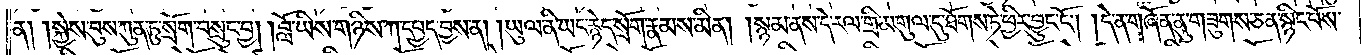

In [10]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [11]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

ན། །སྐྱེས་བུས་ཀུན་ཏུ་སྲོག་བསྲུང་བྱ། །བློ་ཡིས་གཉིས་ཀ་དཔྱད་བྱས་ན། །ཡུལ་ནི་ཡང་རྙེད་སྲོག་རྣམས་མིན། །སྙམ་ནས་དེ་རལ་གྲི་མགུལ་དུ་ཐོགས་ཏེ་ཕྱིར་བྱུང་ངོ༌། །དེ་ན་གཞོན་ནུ་གཟུགས་ཅན་སྙིང་པོས་


Let's create corresponding dataloaders:

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [13]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

model.to(device)

assert model.config.decoder.is_decoder is True
assert model.config.decoder.add_cross_attention is True

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at sangjeedondrub/tibetan-roberta-base and are newly initialized: ['roberta.encoder.layer.5.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.1.crossattention.self.query.bias', 'roberta.encoder.layer.3.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.2.crossattention.self.query.bias', 'roberta.encoder.layer.2.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.2.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention.self.query.weight', 'roberta.encoder.layer.3.crossattention.self.query.bias', 'roberta.encoder.layer.3.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossatten

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [15]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\301212298\AppData\Local\Temp\ipykernel_7856\910432076.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [16]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [17]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
model.save_pretrained(".abc")